In [1]:
import os
import torch
from PIL import Image
from torch import optim
from os.path import join
import matplotlib.pyplot as plt 
from common.lib import splatting
from typing import Iterable, Tuple
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from common.models.motion_field_estimator import get_D, get_G, GANLoss
import matplotlib.pyplot as plt
torch.multiprocessing.set_start_method('spawn')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
G = get_G(3, 2, device=device)
print(G)

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  

In [4]:
D = get_D(2, device=device)
print(D)

MultiscaleDiscriminator(
  (layer0): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (downsample): AvgPool2d(kernel_size=3, stride=2, padding=[1, 1])
)


In [5]:
loss = GANLoss(device=device)

In [6]:
hparams = {
    "epochs": 2,
    "learning_rate_G": 0.001,
    "learning_rate_D": 0.001,
    "batch_size": 1,
}

params = {
    "print_iter": 10,
    "run_name": "first",
}

In [7]:
optimizer_G = optim.Adam(G.parameters(), lr=hparams["learning_rate_G"])
optimizer_D = optim.Adam(D.parameters(), lr=hparams["learning_rate_D"])

In [8]:
class MotionFieldPairs(Dataset):
    def __init__(self, path, device=torch.device("cpu")):
        self.ids = [x[:x.find("_motion.")] for x in [file for file in os.listdir(path) if "pth" in file]]
        self.ids.sort()
        min_size = (612, 1280)
        self.transforms_x = T.Compose([
            T.ToTensor(),
            T.Resize(min_size)
        ])

        self.transforms_y = T.Compose([
            T.Resize(min_size)
        ])
        self.path = path
        self.device = device

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        file_id = self.ids[index]
        motion_file = os.path.join(self.path, "{}_motion.pth".format(file_id))
        img_file = os.path.join(self.path, "{}_input.jpg".format(file_id))
        M = splatting.load_motion_field(motion_file)
        pil_img = Image.open(img_file)
        t_img = self.transforms_x(pil_img)
        M = self.transforms_y(M)
        return t_img, M

valset  = MotionFieldPairs("../data/motion_field/val",   device)
dataset = MotionFieldPairs("../data/motion_field/train", device)

val_dl = DataLoader(valset, hparams["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
train_dl = DataLoader(dataset, hparams["batch_size"], shuffle=True, num_workers=0, pin_memory=True)


In [43]:
batch_index = 1
for i, batch in enumerate(train_dl):
    if i == batch_index:
        first_imgs, first_ms = batch
        break 

In [44]:
first_imgs[0].shape

torch.Size([3, 612, 1280])

In [45]:
def visualize_pair(img, M):
    fig = plt.figure(figsize=(30, 12))
    M_as_img = torch.stack([M[0], torch.zeros(M[0].shape), M[1]])
    fig.add_subplot(121).imshow(M_as_img.permute(1, 2, 0))
    fig.add_subplot(122).imshow(img.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


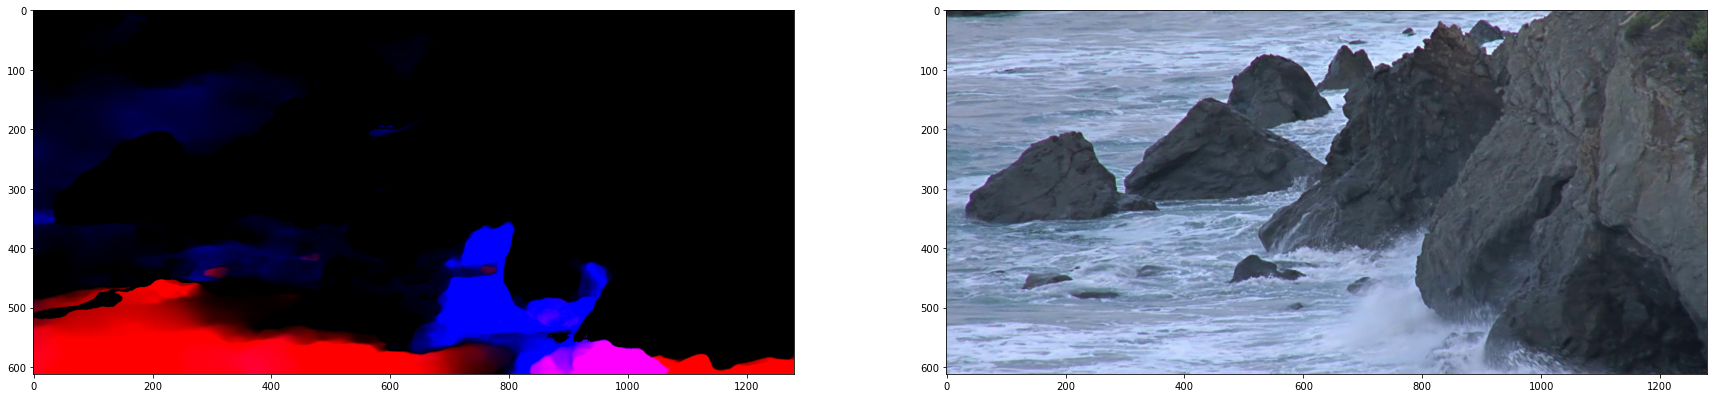

In [46]:
i = 0
visualize_pair(first_imgs[i], first_ms[i])

In [16]:
G_losses = []
D_losses = []
criterion = torch.nn.MSELoss()

def update_D(D, optimizer_D, real, inputs, loss) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    D.zero_grad()

    D_out_real = D(real)

    errD_real = loss(D_out_real, True)
    errD_real.backward()

    D_x = torch.stack(D_out_real[0]).mean().item()

    errD_real = errD_real.cpu()

    fake = G(inputs)
    D_out_fake = D(fake.detach())
    errD_fake = loss(D_out_fake, False).cpu()
    errD_fake.backward()

    D_G_z1 = torch.stack(D_out_fake[0]).mean().item()
    errD = errD_real + errD_fake
    optimizer_D.step()

    return fake, errD.cpu(), D_x, D_G_z1

def update_G(G, D, optimizer_G, fake, loss) -> Tuple[torch.Tensor, torch.Tensor]:
    G.zero_grad()
    out = D(fake)
    errG = loss(out, True) # maybe wrong?
    errG.backward()
    D_G_z2 = torch.stack(out[0]).mean().item()
    optimizer_G.step()
    return D_G_z2, errG.cpu()

def evaluate_G(G, inputs, real, criterion):
    with torch.no_grad():
        fake = G(inputs)
        loss = criterion(fake, real)

    return loss

def evaluate_G_D(G, D, inputs, loss_metric):
    with torch.no_grad():
        fake = G(inputs)
        out = D(fake)
        loss = loss_metric(out, True)
    
    return loss


def save_models(epoch, G_t, D_t, path, id):
    generator, opt_G = G_t
    discriminator, opt_D = D_t

    to_save = {
        "epoch": epoch,
        "G_state_dict": generator.state_dict(),
        "G_opt_state_dict": opt_G.state_dict(),
        "D_state_dict": discriminator.state_dict(),
        "D_opt_state_dict": opt_D.state_dict(),
    }

    final_path = join(path, "{}_{}.model".format(epoch, id))
    torch.save(to_save, final_path)

print("starting...")
for epoch in range(hparams["epochs"]-1):

    for i, data in enumerate(train_dl):
        inputs, real = data
        inputs = inputs.to(device)
        real = real.to(device)

        
        fake, errD, D_x, D_G_z1 = update_D(D, optimizer_D, real, inputs, loss)


        D_G_z2, errG = update_G(G, D, optimizer_G, fake, loss)


        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % params["print_iter"] == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, hparams["epochs"], i, len(dataset),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    val_lossc = 0
    val_lossd = 0
    for inputs, real in val_dl:
        inputs = inputs.to(device)
        real = real.to(device)
        
        val_lossc += evaluate_G(G, inputs, real, criterion).mean().item()
        val_lossd += evaluate_G_D(G, D, inputs, loss).mean().item()

    print("Epoch: {}/{}, Val loss criterion: {}, Val loss D: {}".format(epoch, hparams["epochs"], val_lossc, val_lossd))


# save_models(hparams["epochs"], (G, optimizer_G), (D, optimizer_D), "../models", params["run_name"])


starting...
[0/2][0/4750]	Loss_D: 0.1233	Loss_G: 0.7152	D(x): 0.8144	D(G(z)): 0.1517 / 0.1656
[0/2][10/4750]	Loss_D: 0.3307	Loss_G: 0.6760	D(x): 1.3645	D(G(z)): 0.2296 / 0.1967
[0/2][20/4750]	Loss_D: 0.1034	Loss_G: 1.0147	D(x): 0.7659	D(G(z)): -0.0373 / 0.0044
[0/2][30/4750]	Loss_D: 0.0502	Loss_G: 0.8096	D(x): 1.0687	D(G(z)): 0.1203 / 0.1036
[0/2][40/4750]	Loss_D: 0.0945	Loss_G: 0.7165	D(x): 0.9810	D(G(z)): 0.1721 / 0.1551
[0/2][50/4750]	Loss_D: 0.2413	Loss_G: 0.8123	D(x): 1.2573	D(G(z)): 0.1369 / 0.1079
[0/2][60/4750]	Loss_D: 0.4175	Loss_G: 1.1061	D(x): 0.4694	D(G(z)): 0.0224 / 0.0047
[0/2][70/4750]	Loss_D: 0.3554	Loss_G: 0.8472	D(x): 0.6580	D(G(z)): 0.1008 / 0.0943
[0/2][80/4750]	Loss_D: 0.2196	Loss_G: 0.9527	D(x): 1.0181	D(G(z)): 0.0763 / 0.0455
[0/2][90/4750]	Loss_D: 0.2982	Loss_G: 0.6648	D(x): 0.5291	D(G(z)): 0.1665 / 0.1911
[0/2][100/4750]	Loss_D: 0.1686	Loss_G: 0.8733	D(x): 0.6584	D(G(z)): 0.0455 / 0.0728
[0/2][110/4750]	Loss_D: 0.0605	Loss_G: 0.9366	D(x): 0.9167	D(G(z)): 0.0701

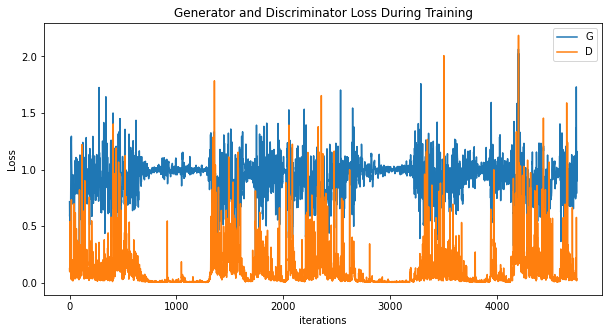

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
save_models(hparams["epochs"], (G, optimizer_G), (D, optimizer_D), "../models", params["run_name"])


In [40]:
G_2 = G.cpu()
fake_m = G(first_imgs)[0]
print(fake_m.shape)

torch.Size([2, 612, 1280])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


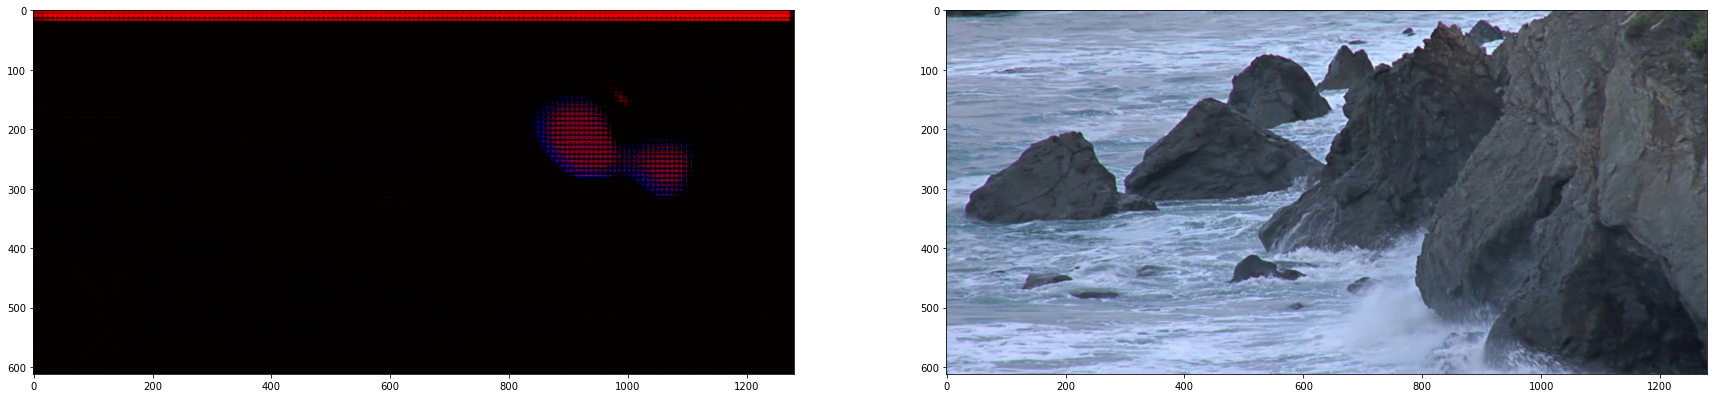

In [47]:
visualize_pair(first_imgs[0].cpu().detach(), fake_m.cpu().detach())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


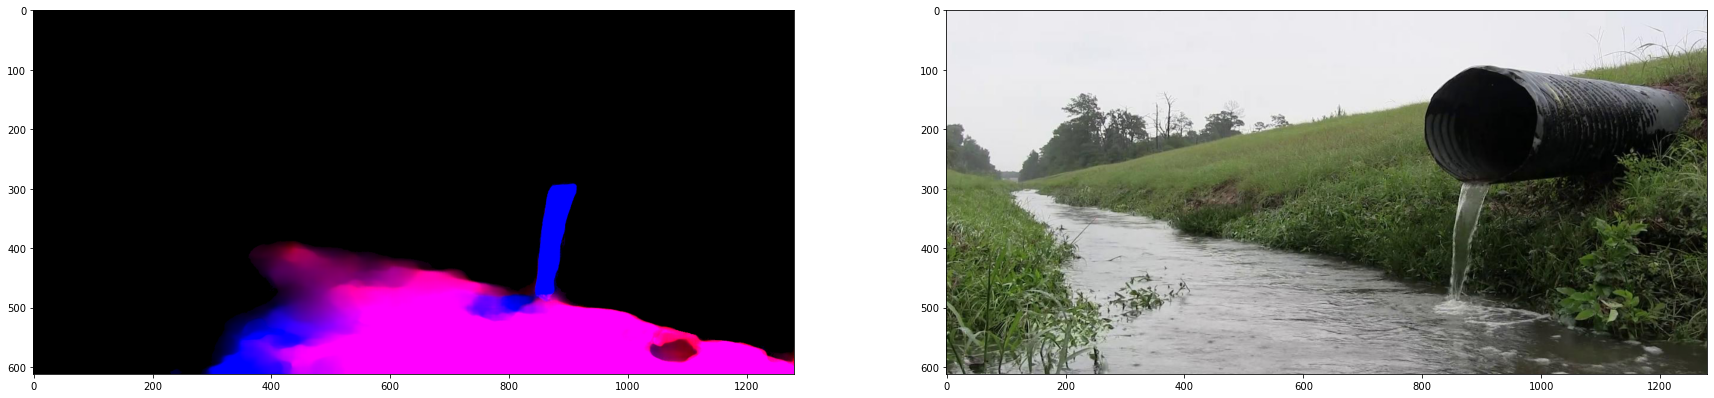

In [41]:
visualize_pair(first_imgs[0], first_ms[0])